In [ ]:
#Text Classification-sentiment analysis
#concept of validation set
#Overfitting
#L2 Regularization and Dropout Regularization
#Transfer learning

In [ ]:
#import libraries
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import re
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
 

In [ ]:
#Load the dataset
train_data=pd.read_csv('/content/drive/MyDrive/sentiment_dataset/train.csv')
test_data=pd.read_csv('/content/drive/MyDrive/sentiment_dataset/test.csv')

In [ ]:
#Remove null values from each row
train_data.dropna(axis=0,how='any',inplace=True)
test_data.dropna(axis=0,how='any',inplace=True)

In [ ]:
#Remove rows with less than 3 words
train_data['num_words']=train_data['text'].apply(lambda x: len(str(x).split()))
mask=train_data['num_words']>2
train_data=train_data[mask]

test_data['num_words']=test_data['text'].apply(lambda x: len(str(x).split()))
mask=test_data['num_words']>2
test_data=test_data[mask]

In [ ]:
#Pre-processing: Remove emoji's,flags, symbols, urls,digits, special characters, etc.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text))

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = str(text).translate(table)
    #print('cleaned:'+text1)
    textArr= str(text1).split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()



In [ ]:
#Applying pre-processing functions of training and test data
train_data['text']=train_data['text'].apply(remove_emoji)
train_data['text']=train_data['text'].apply(remove_url)
train_data['text']=train_data['text'].apply(clean_text)

test_data['text']=test_data['text'].apply(remove_emoji)
test_data['text']=test_data['text'].apply(remove_url)
test_data['text']=test_data['text'].apply(clean_text)


In [ ]:
#Splitting training data into train and validation set
train_x,valid_x,train_y,valid_y=train_test_split(train_data['text'].tolist(),train_data['sentiment'].tolist(),random_state=0,test_size=0.33,stratify=train_data['sentiment'].tolist())

In [ ]:
#Converting sentiments to numerical labels and then applying categorical encoding
le=LabelEncoder()
train_y=le.fit_transform(train_y)
train_y=keras.utils.to_categorical(train_y)
train_y[:1]
valid_y=le.transform(valid_y)
valid_y=keras.utils.to_categorical(valid_y)

test_y=le.transform(test_data['sentiment'].tolist())
test_y=keras.utils.to_categorical(test_y)

In [ ]:
train_x=np.array(train_x)
valid_x=np.array(valid_x)
test_x=np.array(test_data['text'].tolist())

In [ ]:
#Converting x and y arrays into tensor datasets
train_ds=tf.data.Dataset.from_tensor_slices((train_x,train_y))
valid_ds=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
test_ds=tf.data.Dataset.from_tensor_slices((test_x,test_y))

In [ ]:
#Importing pre-trained word vectors from tensorflow hub
embedding='https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'
hub_layer=hub.KerasLayer(embedding,trainable=True,input_shape=[],dtype=tf.string)

In [ ]:
print(train_x[0])

just getting additional free


In [ ]:
hub_layer(train_x[:1])

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[ 0.02252544, -1.102936  , -0.45312536,  1.1712923 , -0.9280152 ,
        -1.6799717 , -0.03097978, -0.04522766, -0.69689393, -0.3546787 ,
        -0.9819268 ,  1.3606595 , -0.7599448 ,  0.05979407, -0.71509284,
         0.48663723,  1.3430784 , -1.0147772 ,  0.13958323, -0.14541228]],
      dtype=float32)>

In [ ]:
#Create a sequential Neural Network
model=keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(3,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile model-define loss function, accuracy, optimizer
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['CategoricalAccuracy'],
              optimizer='adam')

In [ ]:
#Training neural network
history=model.fit(train_ds.batch(128),
          epochs=20,
          validation_data=valid_ds.batch(128))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


141/141 [==============================] - 3s 15ms/step - loss: 1.1741 - categorical_accuracy: 0.3669 - val_loss: 1.0840 - val_categorical_accuracy: 0.4280
Epoch 2/20
141/141 [==============================] - 2s 14ms/step - loss: 1.0435 - categorical_accuracy: 0.4856 - val_loss: 1.0080 - val_categorical_accuracy: 0.5139
Epoch 3/20
141/141 [==============================] - 2s 14ms/step - loss: 0.9590 - categorical_accuracy: 0.5494 - val_loss: 0.9372 - val_categorical_accuracy: 0.5565
Epoch 4/20
141/141 [==============================] - 2s 13ms/step - loss: 0.8826 - categorical_accuracy: 0.6000 - val_loss: 0.8860 - val_categorical_accuracy: 0.5911
Epoch 5/20
141/141 [==============================] - 2s 12ms/step - loss: 0.8187 - categorical_accuracy: 0.6405 - val_loss: 0.8501 - val_categorical_accuracy: 0.6128
Epoch 6/20
141/141 [==============================] - 2s 14ms/step - loss: 0.7673 - categorical_accuracy: 0.6723 - val_loss: 0.8287 - val_categorical_accuracy: 0.6249
Epoch 7/2

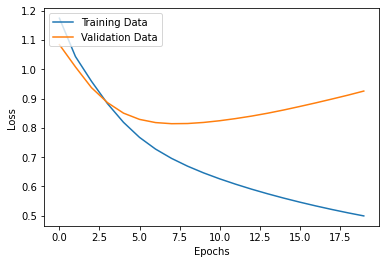

In [ ]:
#ploting training and validation loss
plt.plot(history.history['loss'],label='Training Data')
plt.plot(history.history['val_loss'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

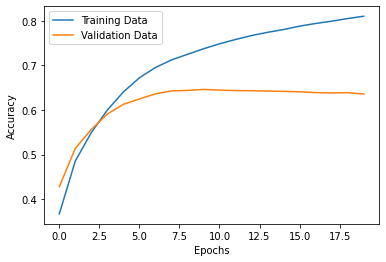

In [ ]:
#ploting training and validation accuracy
plt.plot(history.history['categorical_accuracy'],label='Training Data')
plt.plot(history.history['val_categorical_accuracy'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

CLearly, the model is overfitting

In [ ]:
#Handling overfitting using dropout, L2 regularization
model1=keras.Sequential()
model1.add(hub_layer)
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(10,activation='relu',kernel_regularizer=keras.regularizers.l2(0.05)))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(3,activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.05)))


In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                389380    
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 33        
                                                                 
Total params: 389,623
Trainable params: 389,623
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
               metrics=['CategoricalAccuracy'],
               optimizer='adam')

In [ ]:
history1=model1.fit(train_ds.shuffle(1000).batch(128),
          epochs=60,
          validation_data=valid_ds.batch(128))

Epoch 1/60
141/141 [==============================] - 2s 13ms/step - loss: 1.4202 - categorical_accuracy: 0.4226 - val_loss: 1.2791 - val_categorical_accuracy: 0.4763
Epoch 2/60
141/141 [==============================] - 2s 12ms/step - loss: 1.2362 - categorical_accuracy: 0.4589 - val_loss: 1.1620 - val_categorical_accuracy: 0.5086
Epoch 3/60
141/141 [==============================] - 1s 9ms/step - loss: 1.1404 - categorical_accuracy: 0.4891 - val_loss: 1.0958 - val_categorical_accuracy: 0.5318
Epoch 4/60
141/141 [==============================] - 1s 9ms/step - loss: 1.0969 - categorical_accuracy: 0.4926 - val_loss: 1.0608 - val_categorical_accuracy: 0.5394
Epoch 5/60
141/141 [==============================] - 2s 11ms/step - loss: 1.0653 - categorical_accuracy: 0.5107 - val_loss: 1.0402 - val_categorical_accuracy: 0.5400
Epoch 6/60
141/141 [==============================] - 1s 9ms/step - loss: 1.0508 - categorical_accuracy: 0.5189 - val_loss: 1.0237 - val_categorical_accuracy: 0.5551
E

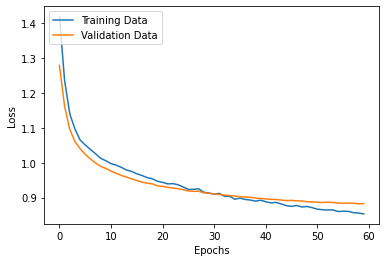

In [ ]:
plt.plot(history1.history['loss'],label='Training Data')
plt.plot(history1.history['val_loss'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

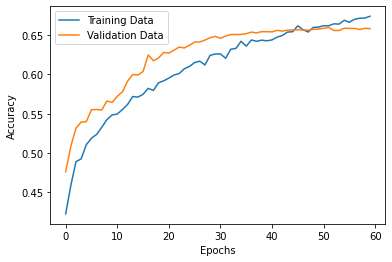

In [ ]:
plt.plot(history1.history['categorical_accuracy'],label='Training Data')
plt.plot(history1.history['val_categorical_accuracy'],label='Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Testing the model on test data
model1.evaluate(test_x,test_y)

108/108 [==============================] - 1s 6ms/step - loss: 0.8686 - categorical_accuracy: 0.6642


[0.8685839772224426, 0.6642399430274963]